# Aplicando GANs para a geração de números (em imagens) 

O objetivo desse exemplo é fazer a geração de números com base nas imagens do MNIST.

Estamos utilizando o banco de imagens de números que é obtido pelo link: http://yann.lecun.com/exdb/mnist/.


In [2]:
import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data
import matplotlib.pyplot as plt
import numpy as np

In [3]:
# Lendo as imagens e fazendo download
mnist = input_data.read_data_sets('mnist/', # As imagens ficarão nesse diretório 
                                  one_hot = True) # Faz a categorização "binária" de múltiplas classes

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting mnist/train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting mnist/train-labels-idx1-ubyte.gz
Instructions for updating:
Please use tf.one_hot on tensors.
Extracting mnist/t10k-images-idx3-ubyte.gz
Extracting mnist/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.


In [4]:
tf.reset_default_graph() # limpando os grafos do tensorflow

In [ ]:
indice = 173

# Visualizando as imagens com fundo branco
%matplotlib inline
plt.imshow(mnist.train.images[indice].reshape(28,28), cmap = 'Greys')

In [ ]:
# Visualizando as imagens com fundo preto
%matplotlib inline
plt.imshow(mnist.train.images[indice].reshape(28,28), cmap = 'gray')

In [ ]:
# Visualizando as imagens originais
%matplotlib inline
plt.imshow(mnist.train.images[indice].reshape(28,28))

#### Fazendo um experimento...

In [ ]:
# Fazendo um experimento...
mnist.train.images[indice]

A ideia é que o gerador consiga gerar uma imagem mais ou menos com essa mesma distribuição de pixels, a fim de ficar o mais próximo possível de imagem que se deseja gerar.

Para simularmos a geração de uma imagem basta que a gente gere números aleatórios e que essa matriz tenha as dimensões da imagem. Como vamos mostrar abaixo:


In [ ]:
# Gerando uma imagem em degrade 
imagem1 = np.arange(0,784).reshape(28,28)
imagem1[:5]# Mostra uma parte do formato de matriz

In [ ]:
# Como temos a matriz, podemos plotar essa imagem
plt.imshow(imagem1)

In [ ]:
# Gerando uma segunda imagem aleatória de fato
imagem2 = np.random.normal(size = 784).reshape(28,28)
plt.imshow(imagem2)

### Voltando a implementar o gerador de imagens

In [15]:
# O ruido_ph vai gerar os número aleatórios
ruido_ph = tf.placeholder(tf.float32, [None, 100]) # vamos gerar 100 valores aleatórios (100 é adequado para 28x28)

In [16]:

# Função que gera as imagens
def gerador(ruido, reuse = tf.AUTO_REUSE):
    
    # Criando um escopo para as variaveis. Assim elas não fica com os mesmo nomes de outras
    with tf.variable_scope('gerador', reuse = reuse):
        # Recebe 100 números aleatórios e vai retornar uma imagem com 784 pixels
        # 100 -> 128 -> 128 -> 784
        camada_oculta1 = tf.nn.relu(tf.layers.dense(inputs = ruido, 
                                                    units = 128)) 
        camada_oculta2 = tf.nn.relu(tf.layers.dense(inputs = camada_oculta1, 
                                                    units = 128))
        camada_saida = tf.layers.dense(inputs = camada_oculta2, 
                                       units = 784, 
                                       activation = tf.nn.tanh)
        
        # As camadas ocultas estão utilizando a função de ativação RELU
        # Enquanto que a camada de saída possui como função de ativação tangente hiperbólica. 
        # Porém poderia ser uma outra também, como a sigmóide por exemplo.
        return camada_saida

In [17]:
# Vai retornar todas as variáveis
variaveis = tf.trainable_variables()
variaveis

[]

In [21]:
# Testando a função geradora
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    
    ruido_teste = np.random.uniform(-1, 1, # entre -1 e 1 porque estamos usando a tangente hiperbólica
                                    size = (1,100)) # Quantidade de número aleatório
#     amostra = sess.run(gerador(ruido_ph, reuse=False), feed_dict = {ruido_ph: ruido_teste})
    amostra = sess.run(gerador(ruido_ph, reuse=True), feed_dict = {ruido_ph: ruido_teste})
    
# OBS IMPORTANTE
# Para executar sem erro esse trecho, tem que executar com o parametro reuse = False e depois com reuse = True.
# Só assim que funciona

In [22]:
# Vai retornar todas as variáveis geradas acima
variaveis = tf.trainable_variables()
variaveis

[<tf.Variable 'gerador/dense/kernel:0' shape=(100, 128) dtype=float32_ref>,
 <tf.Variable 'gerador/dense/bias:0' shape=(128,) dtype=float32_ref>,
 <tf.Variable 'gerador/dense_1/kernel:0' shape=(128, 128) dtype=float32_ref>,
 <tf.Variable 'gerador/dense_1/bias:0' shape=(128,) dtype=float32_ref>,
 <tf.Variable 'gerador/dense_2/kernel:0' shape=(128, 784) dtype=float32_ref>,
 <tf.Variable 'gerador/dense_2/bias:0' shape=(784,) dtype=float32_ref>]

In [ ]:
amostra

In [ ]:
amostra.shape

In [ ]:
# Exibindo a imagem 
plt.imshow(amostra.reshape(28,28))

Podemos ver que é muito semelhante ao que geramos na imagem2, um pouco acima.

### Como fizemos o gerador, agora vamos trabalhar no discriminador

In [24]:
# Criando o placeholder
imagens_reais_ph = tf.placeholder(tf.float32, [None, 784])

# Função que vai ver o quão próxima a imagem gerada está de um imagem real
def discriminador(X, reuse = tf.AUTO_REUSE):
    with tf.variable_scope('discriminador', reuse = reuse):
        # Recebe uma imagem e vai retornar a probabilidade da imagem ser um número
        # 784 -> 128 -> 128 -> 1
        camada_oculta1 = tf.nn.relu(tf.layers.dense(inputs = X,
                                                    units = 128))
        camada_oculta2 = tf.nn.relu(tf.layers.dense(inputs = camada_oculta1, 
                                                    units = 128))
        
        # Ao inves de chamarmos de camada de saída, chamamos de logits pois será uma probilidade
        logits = tf.layers.dense(camada_oculta2, units = 1) # São as previsões sem a normalização 
        return logits

In [ ]:
batch = mnist.train.next_batch(100)
print("batch[0].shape: ", batch[0].shape)

imagens_batch = batch[0].reshape((100, 784)) # variavel auxiliar para passar as imagens para o batch
print("imagens_batch.shape: ", imagens_batch.shape)

In [ ]:
# Visualizando alguma imagem
imagens_batch[0]

In [ ]:
# Como estamos trabalhando com a tangente hiperbólica, vamos transformar os zeros em -1.
# Caso estivessemos trabalhando com a função sigmóide, não precisaríamos fazer essa transformação.
imagens_batch = imagens_batch * 2 - 1
imagens_batch[0]

In [27]:
# Testando a função discriminador
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    
    batch = mnist.train.next_batch(100)
    imagens_batch = batch[0].reshape((100, 784)) # obtem as 100 imagens que era pra estar no lote de 100
    imagens_batch = imagens_batch * 2 - 1 # Faz a transformação de 0 em -1, pois estamos usando tang. hiperbólica
#     resposta = sess.run(discriminador(imagens_reais_ph, reuse = False), feed_dict = {imagens_reais_ph: imagens_batch})
    resposta = sess.run(discriminador(imagens_reais_ph, reuse = True), feed_dict = {imagens_reais_ph: imagens_batch})
    resposta2 = sess.run(tf.nn.sigmoid(resposta))

# OBS IMPORTANTE
# Para executar sem erro esse trecho, tem que executar com o parametro reuse = False e depois com reuse = True.
# Só assim que funciona

In [28]:
# Vai retornar todas as variáveis geradas até agora
variaveis = tf.trainable_variables()
variaveis

[<tf.Variable 'gerador/dense/kernel:0' shape=(100, 128) dtype=float32_ref>,
 <tf.Variable 'gerador/dense/bias:0' shape=(128,) dtype=float32_ref>,
 <tf.Variable 'gerador/dense_1/kernel:0' shape=(128, 128) dtype=float32_ref>,
 <tf.Variable 'gerador/dense_1/bias:0' shape=(128,) dtype=float32_ref>,
 <tf.Variable 'gerador/dense_2/kernel:0' shape=(128, 784) dtype=float32_ref>,
 <tf.Variable 'gerador/dense_2/bias:0' shape=(784,) dtype=float32_ref>,
 <tf.Variable 'discriminador/dense/kernel:0' shape=(784, 128) dtype=float32_ref>,
 <tf.Variable 'discriminador/dense/bias:0' shape=(128,) dtype=float32_ref>,
 <tf.Variable 'discriminador/dense_1/kernel:0' shape=(128, 128) dtype=float32_ref>,
 <tf.Variable 'discriminador/dense_1/bias:0' shape=(128,) dtype=float32_ref>,
 <tf.Variable 'discriminador/dense_2/kernel:0' shape=(128, 1) dtype=float32_ref>,
 <tf.Variable 'discriminador/dense_2/bias:0' shape=(1,) dtype=float32_ref>]

In [ ]:
resposta

In [ ]:
resposta.shape

In [ ]:
resposta2 # Esta retorna probabilidades

### Até agora fizemos tudo de forma isolada. Agora vamos começar a juntar as coisas.

Precisamos juntar as partes para podermos realizar o treinamento.

Importante:

Sabemos que o discriminador recebe as imagens geradas e as imagens reais. Então teremos que chamar o discriminador duas vezes, uma para as imagens reais e uma para as imagens geradas.

In [31]:
logits_imagens_reais = discriminador(imagens_reais_ph)
logits_imagens_ruido = discriminador(gerador(ruido_ph), # passando a imagem gerada
                                     reuse = True) # permite que os pesos sejam os mesmos para as imagens reais e as geradas

In [32]:
# Precisamos definir dois erros, um para o discriminador e um par o gerador
# vamos usar sigmoid_cross_entropy_with_logits porque é mais rápido

# Erro relacionado a quando a resposta é próxima de 1. Ou seja, quando é próximo do que queremos que gere as imagens.
erro_discriminador_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits = logits_imagens_reais, # resposta da rede neural
                                                                                labels = tf.ones_like(logits_imagens_reais) * (0.9))) # indica a resposta real (multiplicamos por 90% para aproximar o valor 1)
# Se colocarmos 1 ao invés de 0.9, pode ser que demore bem mais pra rodar porque o algoritmo vai ficar tentando aproximar ao máximo de 1

# Erro relacionado a quando a resposta é próxima de 0. Ou seja, quando não é próximo do que queremos que gere as imagens.
erro_discriminador_ruido = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits = logits_imagens_ruido,
                                                                                 labels = tf.zeros_like(logits_imagens_ruido)))

# Então somamos os dois tipos de erro do discriminador
# vamos otimizar esse erro, pois ele vai otimizar os outros dois
erro_discriminador = erro_discriminador_real + erro_discriminador_ruido 

# Agora vamos calcular o erro  do gerador. Então compara
erro_gerador = tf.reduce_mean(
                tf.nn.sigmoid_cross_entropy_with_logits(logits = logits_imagens_ruido, # imagem que foi gerada
                labels = tf.ones_like(logits_imagens_ruido)))


In [29]:
# Vai retornar todas as variáveis
variaveis = tf.trainable_variables()
variaveis

[<tf.Variable 'gerador/dense/kernel:0' shape=(100, 128) dtype=float32_ref>,
 <tf.Variable 'gerador/dense/bias:0' shape=(128,) dtype=float32_ref>,
 <tf.Variable 'gerador/dense_1/kernel:0' shape=(128, 128) dtype=float32_ref>,
 <tf.Variable 'gerador/dense_1/bias:0' shape=(128,) dtype=float32_ref>,
 <tf.Variable 'gerador/dense_2/kernel:0' shape=(128, 784) dtype=float32_ref>,
 <tf.Variable 'gerador/dense_2/bias:0' shape=(784,) dtype=float32_ref>,
 <tf.Variable 'discriminador/dense/kernel:0' shape=(784, 128) dtype=float32_ref>,
 <tf.Variable 'discriminador/dense/bias:0' shape=(128,) dtype=float32_ref>,
 <tf.Variable 'discriminador/dense_1/kernel:0' shape=(128, 128) dtype=float32_ref>,
 <tf.Variable 'discriminador/dense_1/bias:0' shape=(128,) dtype=float32_ref>,
 <tf.Variable 'discriminador/dense_2/kernel:0' shape=(128, 1) dtype=float32_ref>,
 <tf.Variable 'discriminador/dense_2/bias:0' shape=(1,) dtype=float32_ref>]

In [23]:
# Salvando as variáveis do gerador
variaveis_gerador = [v for v in variaveis if 'gerador' in v.name]
print([v.name for v in variaveis_gerador])

['gerador/dense/kernel:0', 'gerador/dense/bias:0', 'gerador/dense_1/kernel:0', 'gerador/dense_1/bias:0', 'gerador/dense_2/kernel:0', 'gerador/dense_2/bias:0']


In [30]:
# Salvando as variáveis do discriminador
variaveis_discriminador = [v for v in variaveis if 'discriminador' in v.name]
print([v.name for v in variaveis_discriminador])

['discriminador/dense/kernel:0', 'discriminador/dense/bias:0', 'discriminador/dense_1/kernel:0', 'discriminador/dense_1/bias:0', 'discriminador/dense_2/kernel:0', 'discriminador/dense_2/bias:0']


In [33]:
# Agora que temos acesso as variáveis, vamos realizar o treino das duas redes
treinamento_discriminador = tf.train.AdamOptimizer(learning_rate = 0.001).minimize(erro_discriminador,
                                                                                  var_list = variaveis_discriminador) # Otimiza apenas as variáveis que queremos
treinamento_gerador = tf.train.AdamOptimizer(learning_rate = 0.001).minimize(erro_gerador,
                                                                            var_list = variaveis_gerador)  # Otimiza apenas as variáveis que queremos

In [38]:
batch_size = 100
amostras_teste = [] # para verificarmos a geração das imagens ao longo dos treinos
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    
    print("\nErro D. -> Erro do discriminador\n")
    print("Erro G. -> Erro do Gerador\n")
    
    for epoca in range(300):
        numero_batches = mnist.train.num_examples // batch_size # Obtem a quantidade de lotes que teremos que rodar
        for i in range(numero_batches):
            batch = mnist.train.next_batch(batch_size) # obtem o lote seguinte
            imagens_batch = batch[0].reshape((100, 784)) # obtem as próximas imagens do lote seguinte
            imagens_batch = imagens_batch * 2 - 1 # faz a transformação pois estamos usando tang. hiperbólica
            
            batch_ruido = np.random.uniform(-1, 1, size = (batch_size, 100))
            
            # Treino do discriminador
            _, custod = sess.run([treinamento_discriminador, erro_discriminador], 
                                 feed_dict = {imagens_reais_ph: imagens_batch, 
                                              ruido_ph: batch_ruido})
            
            # Treino do gerador
            _, custog = sess.run([treinamento_gerador, erro_gerador], feed_dict = {ruido_ph: batch_ruido})
            
        
        print('época: ' + str(epoca + 1) + ', Erro D.: ' + str(custod) + ' e Erro G.: ' + str(custog))
        
        # Só obtemos a imagem após termos treinado por uma época
        ruido_teste = np.random.uniform(-1, 1, size = (1, 100))
        imagem_gerada = sess.run(gerador(ruido_ph, reuse = True), feed_dict = {ruido_ph: ruido_teste})
        amostras_teste.append(imagem_gerada) # para vermos a evolução do algoritmo


Erro D. -> Erro do discriminador

Erro G. -> Erro do Gerador

época: 1, Erro D.: 0.44994876 e Erro G.: 3.4419827
época: 2, Erro D.: 0.6142136 e Erro G.: 2.0353105
época: 3, Erro D.: 1.4646771 e Erro G.: 1.2575673
época: 4, Erro D.: 0.4351632 e Erro G.: 8.175152
época: 5, Erro D.: 1.589674 e Erro G.: 1.0523793
época: 6, Erro D.: 2.0319486 e Erro G.: 1.5662521
época: 7, Erro D.: 1.5995435 e Erro G.: 1.0906364
época: 8, Erro D.: 0.96268696 e Erro G.: 3.7382522
época: 9, Erro D.: 0.91856825 e Erro G.: 1.6216065
época: 10, Erro D.: 1.1562093 e Erro G.: 2.0074272
época: 11, Erro D.: 2.815113 e Erro G.: 2.274005
época: 12, Erro D.: 1.0869919 e Erro G.: 1.6791682
época: 13, Erro D.: 2.2853956 e Erro G.: 1.5573287
época: 14, Erro D.: 1.0086231 e Erro G.: 3.0477495
época: 15, Erro D.: 2.6737847 e Erro G.: 1.1726549
época: 16, Erro D.: 1.4917219 e Erro G.: 1.1084039
época: 17, Erro D.: 0.8124872 e Erro G.: 3.527069
época: 18, Erro D.: 0.92536986 e Erro G.: 5.6292458
época: 19, Erro D.: 1.24716 e

época: 160, Erro D.: 1.182055 e Erro G.: 1.1546664
época: 161, Erro D.: 1.3863733 e Erro G.: 1.0662974
época: 162, Erro D.: 1.3088927 e Erro G.: 0.94574326
época: 163, Erro D.: 1.1203063 e Erro G.: 1.2296206
época: 164, Erro D.: 1.1126914 e Erro G.: 1.4186087
época: 165, Erro D.: 1.2442913 e Erro G.: 1.0845933
época: 166, Erro D.: 1.1108679 e Erro G.: 1.4879433
época: 167, Erro D.: 1.0565138 e Erro G.: 1.343333
época: 168, Erro D.: 1.1016808 e Erro G.: 1.1959095
época: 169, Erro D.: 0.956926 e Erro G.: 1.5738997
época: 170, Erro D.: 1.1908548 e Erro G.: 1.1835796
época: 171, Erro D.: 1.0786984 e Erro G.: 1.5152987
época: 172, Erro D.: 1.1622562 e Erro G.: 1.1278623
época: 173, Erro D.: 1.1015161 e Erro G.: 1.3473111
época: 174, Erro D.: 1.1498659 e Erro G.: 1.2125052
época: 175, Erro D.: 1.2077018 e Erro G.: 1.1743629
época: 176, Erro D.: 1.1106342 e Erro G.: 1.4416168
época: 177, Erro D.: 1.2405256 e Erro G.: 1.0905844
época: 178, Erro D.: 1.1080022 e Erro G.: 1.2444919
época: 179, Er

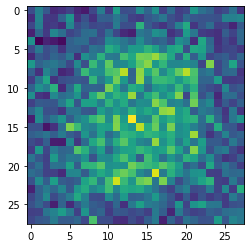

In [39]:
# Agora vamos analisar algumas imagens geradas do começo do treinamento até o final
plt.imshow(amostras_teste[0].reshape(28,28)) # primeira imagem
# Podemos ver que é uma imagem parecida com as que a gente estava gerando aleatoriamente

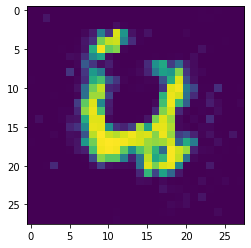

In [40]:
plt.imshow(amostras_teste[int(len(amostras_teste)/2)].reshape(28,28)) # imagem gerada no meio do treinamento

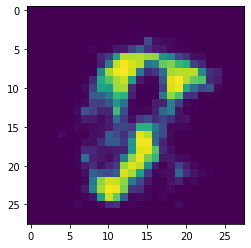

In [41]:
plt.imshow(amostras_teste[-1].reshape(28,28)) # última imagem

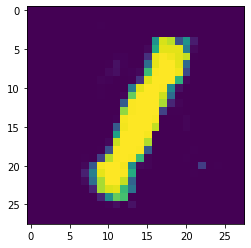

In [42]:
plt.imshow(amostras_teste[-2].reshape(28,28)) # penúltima imagem

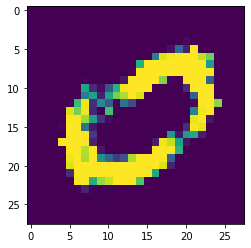

In [43]:
plt.imshow(amostras_teste[-3].reshape(28,28)) # anti penúltima imagem